Creates a dataset with very basic images that can be used to test fine-tuning an object detection model.

The dataset consists of images with a white background with just blue squares, red circles and green triangles, without any overlap. All the images have the same size and the dataset contains annotations with labels and bounding boxes in COCO format (x_min, y_min, width, height). The squares, circles and triangles are all of the same size. Each image contains exactly 1 square, 1 circle and 1 triangle. The dataset is so simple that a model shouldn't need much fine tuning to handle the object detection task: if done correctly, it should be fast on any hardware. Such a dataset should make it fairly easy to test your fine tuning process, before using it on much more complicated datasets.

The structure of the dataset resembles a lot to https://huggingface.co/datasets/cppe-5 , but the images should require less compute power to train on.

The Python code to generate the images can be found at https://github.com/DriesVerachtert/basic_shapes_object_detection

The dataset can be downloaded from https://huggingface.co/datasets/driesverachtert/basic_shapes_object_detection

Dries Verachtert - Apache 2.0

In [1]:
import datasets
from PIL import Image, ImageDraw, ImageColor
import torch
import os
import sys
import numpy as np
import random
import typing
import unittest
import json
from io import StringIO

/Users/verachte/git/github/basic_shapes_object_detection/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set a fixed seed, so we hopefully get the same images each time:

In [2]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

The labels for the 3 types of basic shapes:

In [3]:
category_names: typing.List[str] = ['Square', 'Circle', 'Triangle']

category_name_to_id: typing.Dict[str,int] = {k: i for i,k in enumerate(category_names)}
category_id_to_name: typing.Dict[int,str] = {i: k for i,k in enumerate(category_names)}

A Python class which represents a bounding box in COCO format (x, y, width, height) and a method which checks if 2 bounding boxes overlap or not:

In [4]:
class BoundingBox:
  def __init__(self, x: int, y: int, w: int, h: int):
    self.x: int = x
    self.y: int = y
    self.w: int = w
    self.h: int = h

  def __repr__(self) -> str:
    return f"BoundingBox x:{self.x},y:{self.y},w:{self.w},h:{self.h}"

  def as_list(self) -> typing.List[float]:
    """ return as a list of 4 floats: x, y, w, h """
    return [float(self.x), float(self.y), float(self.w), float(self.h)]

def overlaps(b1: BoundingBox, b2: BoundingBox) -> bool:
  """ return true if this bounding box overlaps with the other bounding box """
  # Check if b1 is to the left of b2 or b2 is to the left of b1
  if b1.x + b1.w < b2.x or b2.x + b2.w < b1.x:
    return False
  # Check if b1 is above b2 or b2 is above b1
  if b1.y + b1.h < b2.y or b2.y + b2.h < b1.y:
    return False
  return True

A class which contains some data about a single generated image: the PNG itself, the 3 bounding boxes (always for a single square, a single circle and a single triangle) and the 3 category IDs (always Square, Circle and Triangle).

The class also contains a method which generates a single line of json containing the name, boundingboxes and so on and which is needed to generate the metadata file for the dataset at the HuggingFace hub.

In [7]:
class ImageData:
  def __init__(self, gen_image: Image.Image, square: BoundingBox, circle: BoundingBox, triangle: BoundingBox):
    self.gen_image: Image.Image = gen_image
    self.square: BoundingBox = square
    self.circle: BoundingBox = circle
    self.triangle: BoundingBox = triangle

  def get_bboxes(self) -> typing.List[typing.List[float]]:
    """ return a list of the bounding boxes.
    Each bounding box consists of 4 floats: x, y, w, h """
    return [self.square.as_list(), self.circle.as_list(), self.triangle.as_list()]

  def get_bboxes_areas(self) -> typing.List[float]:
    """ return a list of the areas of the bounding boxes.
    Each bounding box consists of 4 floats: x, y, w, h """
    return [self.square.w*self.square.h, self.circle.w*self.circle.h, self.triangle.w*self.triangle.h]

  def get_categories(self) -> typing.List[int]:
    """ get the categories of each of the bounding boxes
    as each image has a fixed list of objects consisting of a square, circle and triangle, 
    is this list of categories also fixed """
    return [0, 1, 2]

  def json_for_dataset_metadata(self, file_name: str, image_id: int, bbox_id_generator: typing.Iterator[int]) -> str:
    """ generate the metadata in json format for the huggingface dataset """
    metadata = {}
    metadata['file_name'] = file_name
    metadata['image_id'] = image_id
    metadata['width'] = self.gen_image.width
    metadata['height'] = self.gen_image.height
    metadata['objects'] = {}
    metadata['objects']['id'] = [next(bbox_id_generator), next(bbox_id_generator), next(bbox_id_generator)]
    metadata['objects']['area'] = self.get_bboxes_areas()
    metadata['objects']['bbox'] = self.get_bboxes()
    metadata['objects']['category'] = self.get_categories()
    retval = StringIO()
    json.dump(metadata, retval)
    return retval.getvalue()

generate_single_image: a method which generates a single image, which results in an ImageData object.

The 3 shapes are randomly placed, but without overlap.

In [8]:
def generate_single_image() -> ImageData:
  """ Generate an image which can be used for very simplistic object detection """
  # Create an image with a white background
  img_width: int = 200
  img_height: int = 200
  border: int = 5
  image: Image.Image = Image.new('RGB', (img_width, img_height), 'white')
  draw: ImageDraw.ImageDraw = ImageDraw.Draw(image)

  # Add the blue square at a random place
  square_size: int = 30
  square_x: int = random.randint(border, img_width - square_size - border)
  square_y: int = random.randint(border, img_height - square_size - border)
  square_bbox: BoundingBox = BoundingBox(square_x, square_y, square_size, square_size)
  draw.rectangle(((square_x, square_y), (square_x+square_size, square_y+square_size)), fill='blue')

  # Find an unoccupied spot for a red circle
  circle_diameter: int = 30
  circle_bbox_x: int = -1
  circle_bbox_y: int = -1
  circle_bbox: BoundingBox
  circle_location_found: bool = False
  while not circle_location_found:
    circle_bbox_x = random.randint(border, img_width - circle_diameter - border)
    circle_bbox_y = random.randint(border, img_height - circle_diameter - border)
    circle_bbox = BoundingBox(circle_bbox_x, circle_bbox_y, circle_diameter, circle_diameter)
    circle_location_found = not overlaps(circle_bbox, square_bbox)
  draw.ellipse(((circle_bbox_x, circle_bbox_y),(circle_bbox_x+circle_diameter, circle_bbox_y+circle_diameter)),fill='red')

  # Find an unoccupied spot for a green triangle, downward
  triangle_x: int = -1
  triangle_y: int = -1
  triangle_size: int = 15
  triangle_bbox: BoundingBox
  triangle_location_found: bool = False
  while not triangle_location_found:
    triangle_x = random.randint(border, img_width - 2*triangle_size - border)
    triangle_y = random.randint(border, img_height - triangle_size - border)
    triangle_bbox = BoundingBox(triangle_x, triangle_y, 2*triangle_size, triangle_size)
    triangle_location_found = not overlaps(circle_bbox, triangle_bbox) and not overlaps(square_bbox, triangle_bbox)
  draw.polygon(((triangle_x, triangle_y),(triangle_x+2*triangle_size, triangle_y), (triangle_x+triangle_size, triangle_y+triangle_size)), fill='green')

  return ImageData(image, square_bbox, circle_bbox, triangle_bbox)

A TestCase which checks if the bounding boxes are correct by checking the color of some pixels within and around the bounding box, and which also checks that the bounding boxes are not overlapping.

In [9]:
class ImageDataTestCase(unittest.TestCase):
  def check_bbox_within_image(self, img: Image.Image, bbox: BoundingBox):
    """ Helper function which checks 1 bounding box """
    img_width: int = img.width
    img_height: int = img.height
    self.assertTrue(bbox.x > 0, str(bbox))
    self.assertTrue(bbox.y > 0, str(bbox))
    self.assertTrue(bbox.w > 0, str(bbox))
    self.assertTrue(bbox.h > 0, str(bbox))
    self.assertTrue(bbox.x < img_width - bbox.w, str(bbox))
    self.assertTrue(bbox.y < img_height - bbox.h, str(bbox))
    self.assertTrue(bbox.x + bbox.w < img_width, str(bbox))
    self.assertTrue(bbox.y + bbox.h < img_height, str(bbox))

  def check_color_of_pixel(self, img: Image.Image, x: int, y: int, color: str):
    """ Check if a pixel at x,y has a certain color. Color should be a valid name according to PIL ImageColor """
    pixel_color = img.getpixel((x,y))
    named_color = ImageColor.getcolor(color, 'RGB')
    self.assertEqual(pixel_color, named_color)

  def test_retval_not_none(self):
    img_data: ImageData = generate_single_image()
    self.assertIsNotNone(img_data)
    self.assertIsNotNone(img_data.gen_image)
    self.assertIsNotNone(img_data.square)
    self.assertIsNotNone(img_data.circle)
    self.assertIsNotNone(img_data.triangle)

  def test_circle(self):
    img_data: ImageData = generate_single_image()
    c: BoundingBox = img_data.circle
    self.check_bbox_within_image(img_data.gen_image, c)
    self.check_color_of_pixel(img_data.gen_image, int(c.x+(c.w/2)), c.y+1, 'red')
    self.check_color_of_pixel(img_data.gen_image, int(c.x+(c.w/2)), c.y-1, 'white')
    self.check_color_of_pixel(img_data.gen_image, int(c.x+(c.w/2)), c.y+c.h-1, 'red')
    self.check_color_of_pixel(img_data.gen_image, int(c.x+(c.w/2)), c.y+c.h+1, 'white')

  def test_square(self):
    img_data: ImageData = generate_single_image()
    s: BoundingBox = img_data.square
    self.check_bbox_within_image(img_data.gen_image, s)
    self.check_color_of_pixel(img_data.gen_image, s.x+1, s.y+1, 'blue')
    self.check_color_of_pixel(img_data.gen_image, s.x-1, s.y, 'white')
    self.check_color_of_pixel(img_data.gen_image, s.x, s.y-1, 'white')
    self.check_color_of_pixel(img_data.gen_image, s.x+s.w-1, s.y+s.h-1, 'blue')
    self.check_color_of_pixel(img_data.gen_image, s.x+s.w+1, s.y+s.h, 'white')
    self.check_color_of_pixel(img_data.gen_image, s.x+s.w, s.y+s.h+1, 'white')

  def test_triangle(self):
    img_data: ImageData = generate_single_image()
    t: BoundingBox = img_data.triangle
    self.check_bbox_within_image(img_data.gen_image, t)
    self.check_color_of_pixel(img_data.gen_image, t.x+1, t.y+1, 'green')
    self.check_color_of_pixel(img_data.gen_image, t.x-1, t.y, 'white')
    self.check_color_of_pixel(img_data.gen_image, t.x, t.y-1, 'white')
    self.check_color_of_pixel(img_data.gen_image, t.x+t.w-1, t.y+1, 'green')
    self.check_color_of_pixel(img_data.gen_image, t.x+t.w+1, t.y, 'white')

def run_tests():
    loader = unittest.TestLoader()
    suite = loader.loadTestsFromTestCase(ImageDataTestCase)
    runner = unittest.TextTestRunner()
    runner.run(suite)
run_tests()

....
----------------------------------------------------------------------
Ran 4 tests in 0.002s

OK


In hindsight, the testcase probably doesn't handle certain corner cases where 2 shapes are located next to each other... There's always room for improvement.

Generate the files for the dataset in the directory basic_shapes_object_detection. The dataset will contain 2 splits:

* train: 1000 images
* test: 30 images

This will generate the 1030 images and also the metadata.jsonl files for both splits.

In [10]:
dataset_dir = "basic_shapes_object_detection"
train_dir = f"{dataset_dir}/train"
test_dir = f"{dataset_dir}/test"
train_metadata_file = f"{train_dir}/metadata.jsonl"
test_metadata_file = f"{test_dir}/metadata.jsonl"

os.makedirs(train_dir, exist_ok = True)
os.makedirs(test_dir, exist_ok = True)

train_metadata: StringIO = StringIO()

num_images: int = 1000
bbox_id_generator: typing.Iterator[int] = iter(range(0,3*num_images))
for i in range(0, num_images):
  img_data: ImageData = generate_single_image()
  file_name = f"{i:04}.png"
  img_data.gen_image.save(f"{train_dir}/{file_name}", format="PNG")
  train_metadata.write(img_data.json_for_dataset_metadata(file_name, i, bbox_id_generator) + "\n")
with open(train_metadata_file, 'w') as fd:
  fd.write(train_metadata.getvalue())

test_metadata: StringIO = StringIO()
num_images = 30
bbox_id_generator = iter(range(0,3*num_images))
for i in range(0, num_images):
  img_data: ImageData = generate_single_image()
  file_name = f"{i:04}.png"
  img_data.gen_image.save(f"{test_dir}/{file_name}", format="PNG")
  test_metadata.write(img_data.json_for_dataset_metadata(file_name, i, bbox_id_generator) + "\n")
with open(test_metadata_file, 'w') as fd:
  fd.write(test_metadata.getvalue())

The goal is to create a dataset which resembles https://huggingface.co/datasets/cppe-5

That dataset seems to contain the followoing features:

* image_id: Value(dtype='int64', id=None)
* image: Image(decode=True, id=None)
* width: Value(dtype='int32', id=None)
* height: Value(dtype='int32', id=None)
* objects: Sequence(feature={'id': Value(dtype='int64', id=None), 'area': Value(dtype='int64', id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), 'category': ClassLabel(names=['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask'], id=None)}, length=-1, id=None)

'objects' in more detail:
* id: Value(dtype='int64', id=None)
* area: Value(dtype='int64', id=None)
* bbox: Sequence(feature=Value(dtype='float32', id=None), length=4, id=None)
* category: ClassLabel(names=['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask'], id=None)

Recreate the same sequences of features and create the dataset of type 'imagefolder':

In [11]:
features = datasets.Features({
  'image_id': datasets.Value(dtype='int64'),
  'image': datasets.Image(),
  'width': datasets.Value(dtype='int32'),
  'height': datasets.Value(dtype='int32'),
  'objects': datasets.Sequence(feature={
    'id': datasets.Value(dtype='int64'),
    'area': datasets.Value(dtype='int64'),
    'bbox': datasets.Sequence(feature=datasets.Value(dtype='float32'), length=4),
    'category': datasets.ClassLabel(names=['Square','Circle','Triangle'])
  })
})

dataset: datasets.DatasetDict = typing.cast(datasets.DatasetDict, datasets.load_dataset("imagefolder", data_dir=dataset_dir, features=features))

Generating train split: 1000 examples [00:00, 13401.92 examples/s]
Generating test split: 30 examples [00:00, 6447.49 examples/s]


Now upload the the dataset to HuggingFace as 'driesverachtert/basic_shapes_object_detection':

In [12]:
import huggingface_hub
hf_token: typing.Optional[str] = huggingface_hub.HfFolder.get_token()
if hf_token is None:
  print("You first need to login to use the HugginFace hub")
else:
  dataset.push_to_hub('driesverachtert/basic_shapes_object_detection', private=False, token=hf_token)


Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Also add a 'repo card' with some metadata such as tags and the license:

In [27]:
readme_file: str = "README.md"
readme_contents: str
with open(readme_file, 'r') as file:
  readme_contents = file.read()
card = huggingface_hub.repocard.RepoCard(readme_contents)
if hf_token is None:
  print("You first need to login to use the HugginFace hub")
else:
  card.push_to_hub('driesverachtert/basic_shapes_object_detection', token=hf_token, repo_type="dataset")


Verify if the features of this dataset match the structure of the cppe-5 dataset:

In [14]:
print(dataset)

train_ds: datasets.Dataset = dataset['train']

for key in train_ds.features:
  print(key + ": " + str(train_ds.features[key]))

print("\n'objects' in more detail:")
objects_features: datasets.Sequence = typing.cast(datasets.Sequence, train_ds.features['objects'])
for key in objects_features.feature:
  print(key + ": " + str(objects_features.feature[key]))

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 30
    })
})
image_id: Value(dtype='int64', id=None)
image: Image(decode=True, id=None)
width: Value(dtype='int32', id=None)
height: Value(dtype='int32', id=None)
objects: Sequence(feature={'id': Value(dtype='int64', id=None), 'area': Value(dtype='int64', id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), 'category': ClassLabel(names=['Square', 'Circle', 'Triangle'], id=None)}, length=-1, id=None)

'objects' in more detail:
id: Value(dtype='int64', id=None)
area: Value(dtype='int64', id=None)
bbox: Sequence(feature=Value(dtype='float32', id=None), length=4, id=None)
category: ClassLabel(names=['Square', 'Circle', 'Triangle'], id=None)


Print some information about one of the images in the dataset:

In [15]:
def print_info_single_image(img_data: typing.Dict) -> None:
  image_id: int = img_data['image_id']
  image: Image.Image = img_data['image']
  width: int = img_data['width']
  height: int = img_data['height']
  object_id: typing.List[int] = img_data['objects']['id']
  object_area: typing.List[int] = img_data['objects']['area']
  object_bbox: typing.List[typing.List[int]] = img_data['objects']['bbox']
  object_category: typing.List[int] = img_data['objects']['category']
  print(f"Image with id {image_id}, width {width} and height {height} and {len(object_id)} objects:")
  for i, id in enumerate(object_id):
    cat_id: int = object_category[i]
    cat_name: str = category_names[cat_id]
    print(f"object {i} with id {id}, area {object_area[i]}, bbox {object_bbox[i]}, category {cat_id}: {cat_name}")

img_data: typing.Dict = dataset["train"][0]
print(img_data)

print_info_single_image(img_data)

{'image_id': 0, 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x15F224710>, 'width': 200, 'height': 200, 'objects': {'id': [0, 1, 2], 'area': [900, 900, 450], 'bbox': [[155.0, 76.0, 30.0, 30.0], [6.0, 45.0, 30.0, 30.0], [113.0, 92.0, 30.0, 15.0]], 'category': [0, 1, 2]}}
Image with id 0, width 200 and height 200 and 3 objects:
object 0 with id 0, area 900, bbox [155.0, 76.0, 30.0, 30.0], category 0: Square
object 1 with id 1, area 900, bbox [6.0, 45.0, 30.0, 30.0], category 1: Circle
object 2 with id 2, area 450, bbox [113.0, 92.0, 30.0, 15.0], category 2: Triangle


Show some of the generated images in the dataset:

* The first method adds the bounding boxes with their labels on a single image
* The second method uses the first method to show a grid of images with their bounding boxes and labels

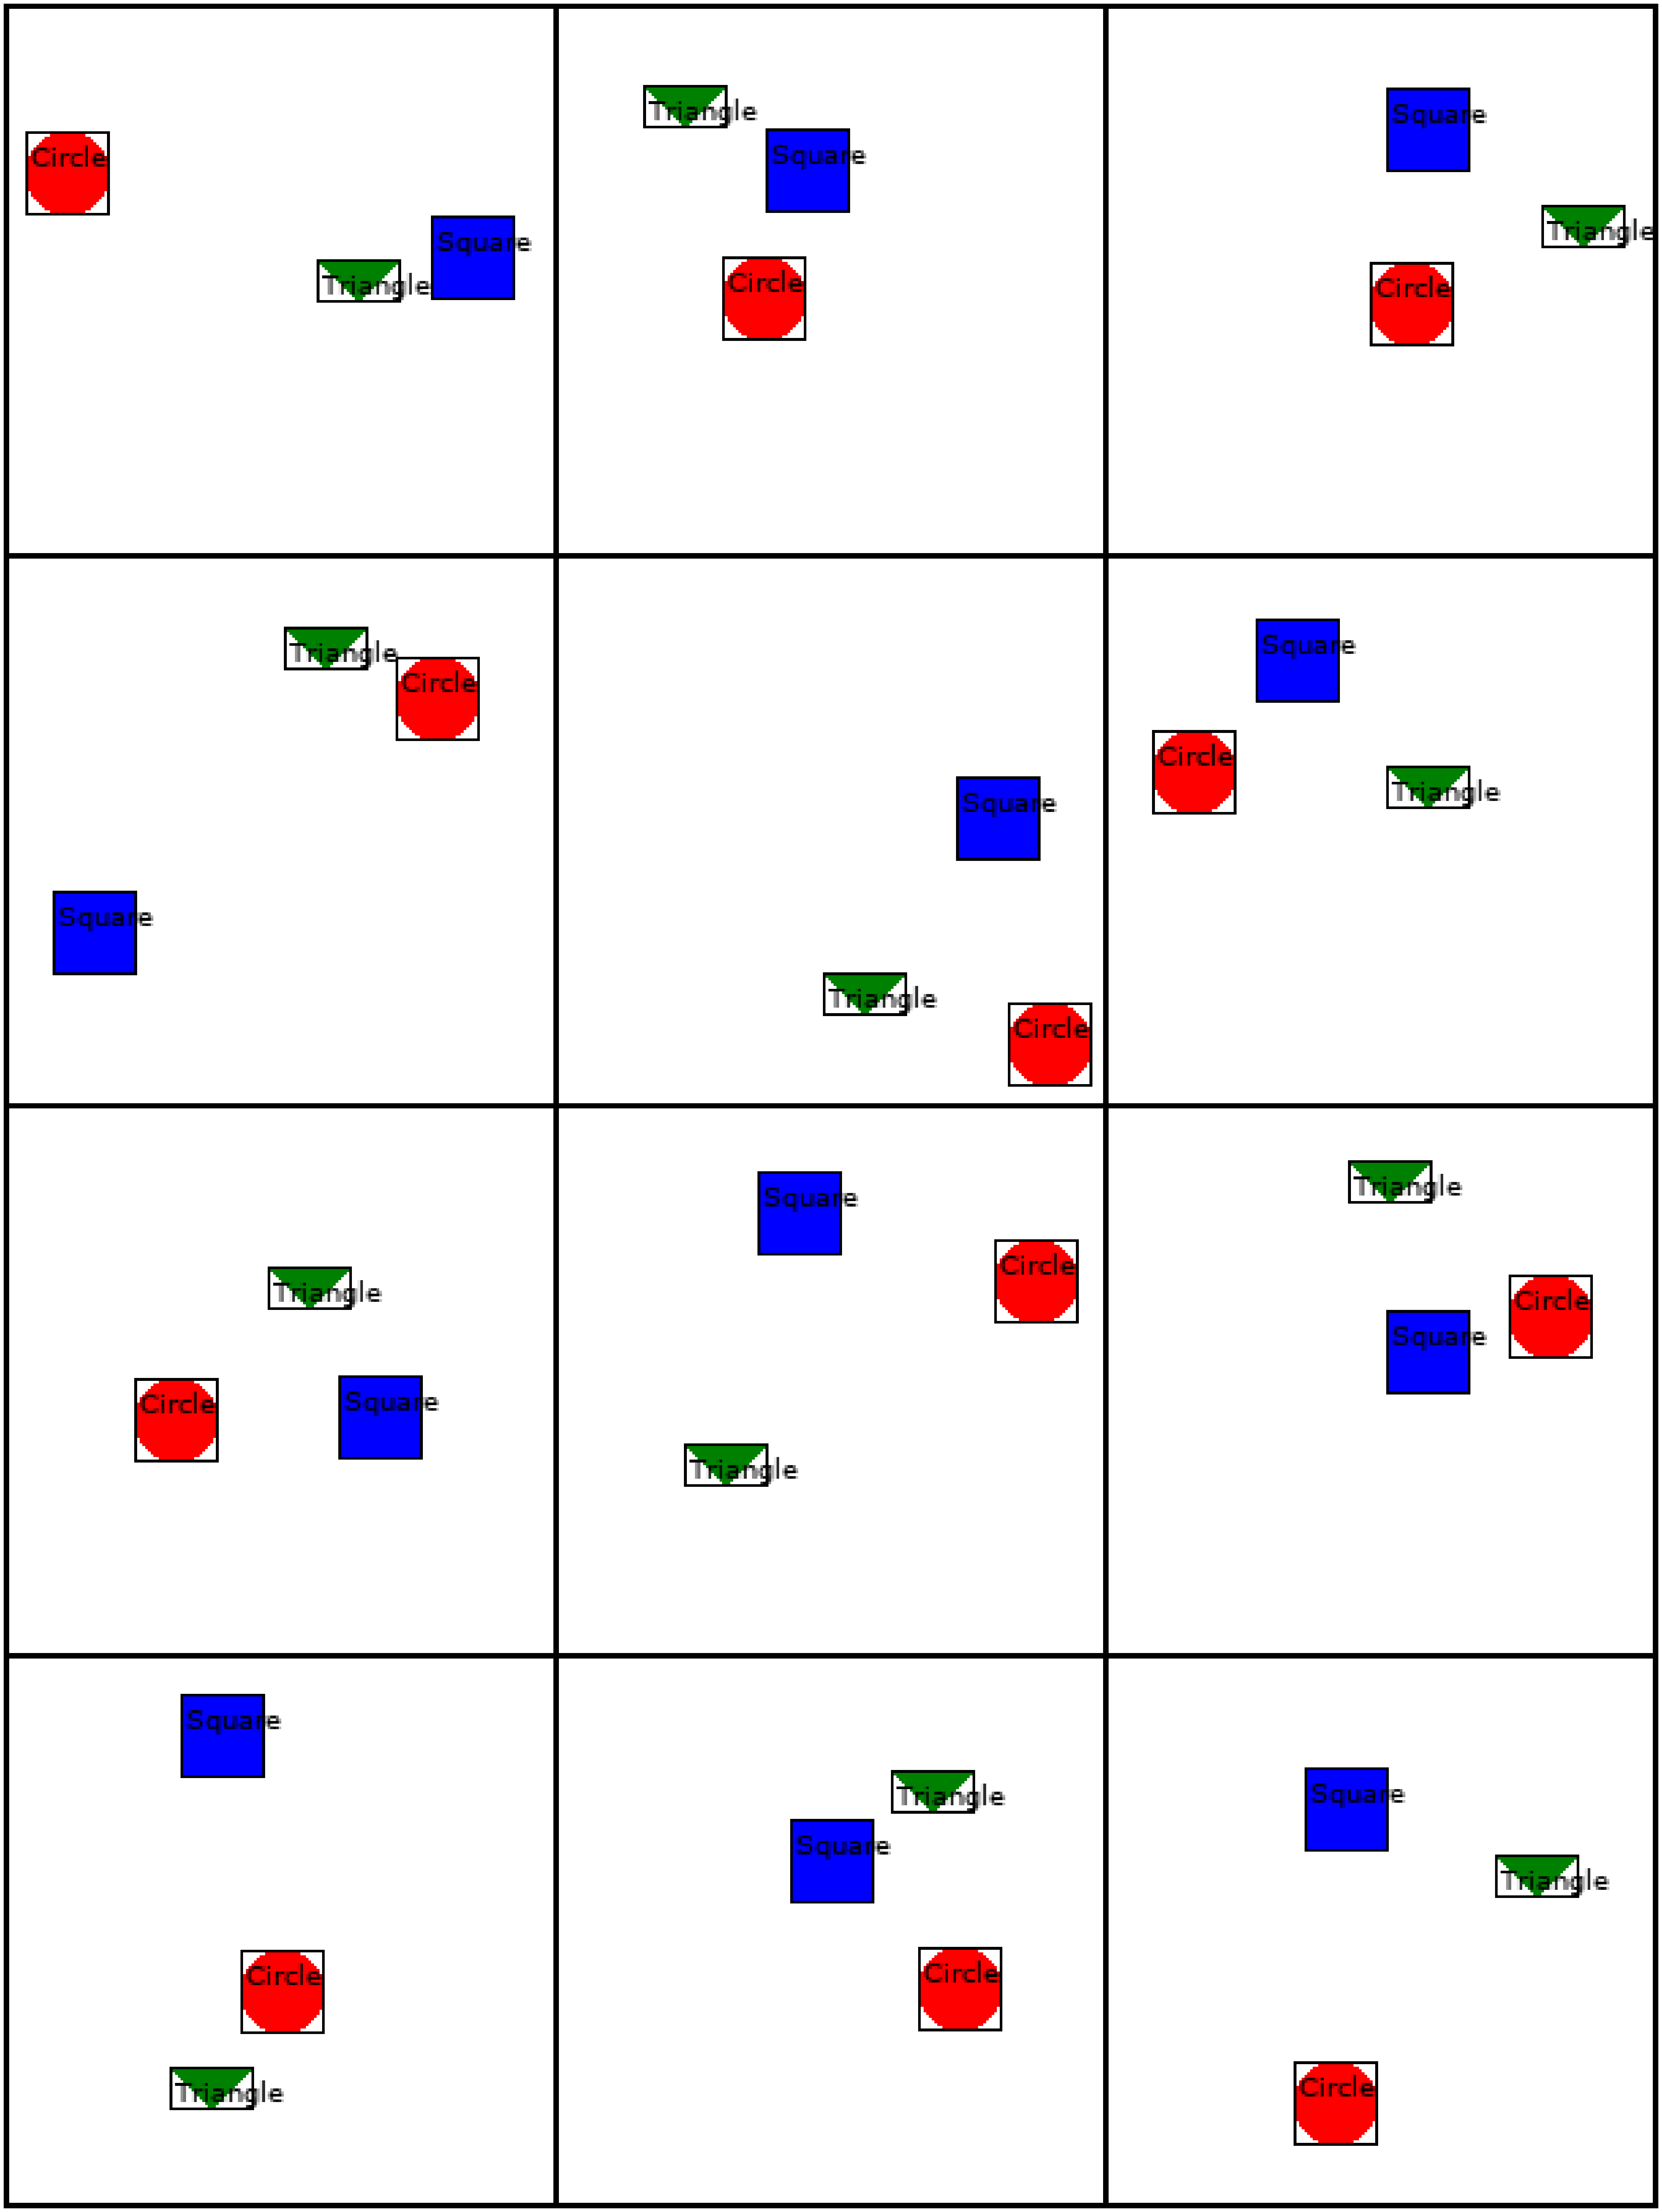

In [22]:
import torchvision.transforms as tvtransforms
import torchvision.transforms.functional as tvfunctional
import torchvision.ops as tvops

from torchvision.utils import make_grid
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import torch
import math

def create_single_image_with_annotations(img_data: typing.Dict, font: str = "Verdana", box_width: int = 1, font_size: int = 10) -> Image.Image:
  """ Create an image with the bounding boxes and labels applied """
  img_as_tensor: torch.Tensor = tvfunctional.pil_to_tensor(img_data['image'])
  # draw_bounding_boxes expects boxes in xmin, ymin, xmax, ymax format,
  # while this dataset uses x,y, width, height. => torchvision has some conversion function
  boxes: torch.Tensor = tvops.box_convert(torch.tensor(img_data['objects']['bbox']), 'xywh', 'xyxy')
  labels: typing.List[str] = [category_names[i] for i in  img_data['objects']['category']]
  image_with_boxes: torch.Tensor = torchvision.utils.draw_bounding_boxes(image=img_as_tensor,
                                        boxes=boxes,
                                        labels=labels,
                                        colors='black',
                                        fill=False,
                                        width=box_width,
                                        font=font,
                                        font_size=font_size)
  return tvfunctional.to_pil_image(image_with_boxes)



def show_images_in_grid(img_data_list: datasets.Dataset):
  ''' Show a bunch of images with their annotations in a grid with 2 images per row '''
  images: typing.List[Image.Image] = [create_single_image_with_annotations(typing.cast(typing.Dict, img_data), font_size=10, box_width=1) for img_data in img_data_list]
  # Transform the images to tensor
  # TODO: convert create_single_image_with_annotations also to such a transformation
  transform = tvtransforms.Compose([
      tvtransforms.Resize((200, 200)),
      tvtransforms.ToTensor()
  ])
  tensors = [transform(img) for img in images]
  # combine the images into 1 big tensor
  batch = torch.stack(tensors)
  # make a grid of images with 2 images per row
  grid_img = make_grid(batch, nrow=3)

  num_rows: int = math.ceil(float(len(img_data_list))/3.)
  width_height_per_image: int = 15
  plt.figure(figsize=(width_height_per_image*3, num_rows*width_height_per_image))

  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off')
  plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
  plt.show()

first_twelf_images: datasets.Dataset = dataset['train'].select(range(0,12))
show_images_in_grid(first_twelf_images)